# Compare GPs + Plot

In [1]:
import fastgp
import qmcpy as qp
import numpy as np
import torch
import pandas as pd
from matplotlib import pyplot
import tueplots.figsizes

In [2]:
torch.set_default_dtype(torch.float64)
device = "cpu"

In [3]:
colors = ["xkcd:"+color[:-1] for color in pd.read_csv("../../../xkcd_colors.txt",comment="#").iloc[:,0].tolist()][::-1]
_alpha = 0.25
WIDTH = 2*(500/72)
LINEWIDTH = 3
MARKERSIZE = 100

## True Function

In [4]:
d = 1 
f = lambda x: 10*x[:,0]*torch.sin(10*x[:,0]) 
fp = lambda x: 100*x[:,0]*torch.cos(10*x[:,0])+10*torch.sin(10*x[:,0]) 
xticks = torch.linspace(0,1,252)[1:-1,None]
yticks = f(xticks)
ypticks = fp(xticks)
print("xticks.shape = %s"%str(tuple(xticks.shape)))
print("yticks.shape = %s"%str(tuple(yticks.shape)))
print("ypticks.shape = %s"%str(tuple(ypticks.shape)))

xticks.shape = (250, 1)
yticks.shape = (250,)
ypticks.shape = (250,)


## Fast GP Construction

In [5]:
fgp_std = fastgp.StandardGP(
    seqs = [qp.DigitalNetB2(1,seed=11,randomize="DS"),qp.DigitalNetB2(1,seed=17,randomize="DS")],
    num_tasks = 2,
    derivatives = [torch.tensor([0]),torch.tensor([1])],
)
fgp_net = fastgp.FastGPDigitalNetB2(
    seqs = [qp.DigitalNetB2(1,seed=7,randomize="DS"),qp.DigitalNetB2(1,seed=17,randomize="DS")],
    num_tasks = 2,
    alpha = 4,
    derivatives = [torch.tensor([0]),torch.tensor([1])],
)
fgp_lat = fastgp.FastGPLattice(
    seqs = [qp.Lattice(1,seed=7),qp.Lattice(1,seed=17)],
    num_tasks = 2,
    alpha = 4,
    derivatives = [torch.tensor([0]),torch.tensor([1])],
)
gps = [fgp_std,fgp_net,fgp_lat]

## GP Fitting

In [6]:
pmeans = [None]*len(gps)
pci_lows = [None]*len(gps)
pci_highs = [None]*len(gps)
for i,gp in enumerate(gps):
    print(type(gp).__name__)
    x_next = gp.get_x_next(n=[2**4,2**3])
    gp.add_y_next([f(x_next[0]),fp(x_next[1])])
    gp.fit()
    pmeans[i],_,_,pci_lows[i],pci_highs[i] = gp.post_ci(xticks,confidence=0.95)


StandardGP
     iter of 5.0e+03 | NMLL       | norm term  | logdet term
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 2.23e+09   | 2.23e+09   | -2.30e+02 
            5.00e+00 | 7.74e+07   | 7.74e+07   | -1.99e+02 
            1.00e+01 | 4.67e+02   | 4.97e+02   | -7.42e+01 
            1.50e+01 | 5.61e+01   | 1.15e+01   | 4.52e-01  
            2.00e+01 | 5.13e+01   | 2.31e+01   | -1.59e+01 
            2.50e+01 | 5.13e+01   | 2.39e+01   | -1.67e+01 
            3.00e+01 | 5.10e+01   | 2.11e+01   | -1.42e+01 
            3.50e+01 | 5.08e+01   | 2.10e+01   | -1.43e+01 
            4.00e+01 | 5.08e+01   | 2.05e+01   | -1.38e+01 
            4.20e+01 | 5.08e+01   | 2.04e+01   | -1.37e+01 
FastGPDigitalNetB2
     iter of 5.0e+03 | NMLL       | norm term  | logdet term
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 3.77e+03   | 3.72e+03   | 4.04e+00  
            5.00e+00 | 9.23e+02   | 8.40e+02   | 3.91e+01  
      

## Plot

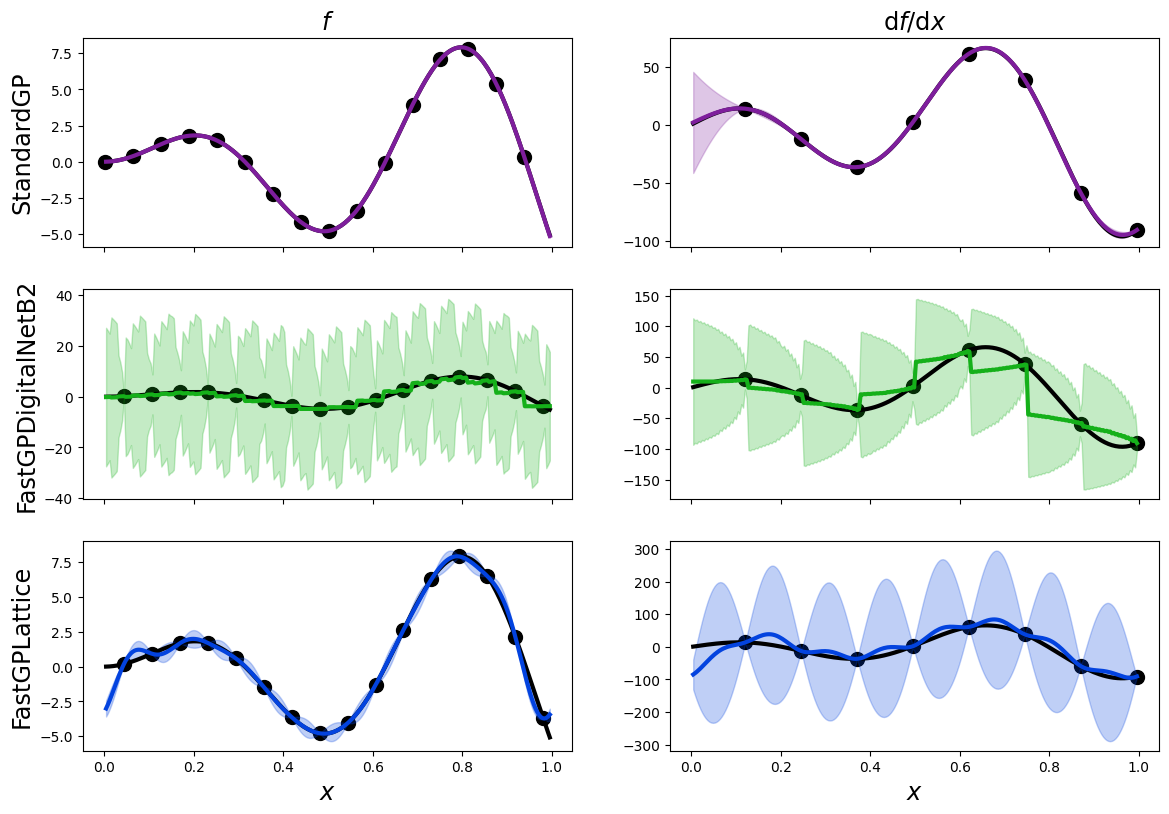

In [7]:
fig,ax = pyplot.subplots(nrows=len(gps),ncols=2,figsize=(WIDTH,WIDTH/len(gps)*2),sharex=True,sharey=False)
for i,gp in enumerate(gps):
    ax[i,0].set_ylabel(type(gp).__name__,fontsize="xx-large")
    ax[i,0].plot(xticks[:,0],yticks,color="k",linewidth=LINEWIDTH)
    ax[i,1].plot(xticks[:,0],ypticks,color="k",linewidth=LINEWIDTH)
    ax[i,0].scatter(gp.x[0][:,0],gp.y[0],color="k",s=MARKERSIZE)
    ax[i,1].scatter(gp.x[1][:,0],gp.y[1],color="k",s=MARKERSIZE)
    ax[i,0].plot(xticks[:,0],pmeans[i][0],color=colors[i],linewidth=LINEWIDTH)
    ax[i,1].plot(xticks[:,0],pmeans[i][1],color=colors[i],linewidth=LINEWIDTH)
    ax[i,0].fill_between(xticks[:,0],pci_lows[i][0],pci_highs[i][0],color=colors[i],alpha=_alpha)
    ax[i,1].fill_between(xticks[:,0],pci_lows[i][1],pci_highs[i][1],color=colors[i],alpha=_alpha)
ax[0,0].set_title(r"$f$",fontsize="xx-large")
ax[0,1].set_title(r"$\mathrm{d} f / \mathrm{d} x$",fontsize="xx-large")
for j in range(2):
    ax[-1,j].set_xlabel(r"$x$",fontsize="xx-large")
fig.savefig("./gps_deriv.pdf",bbox_inches="tight")